In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 1.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda id = 1.0


Computing l1 cost


591it [00:29, 20.09it/s]


l1 cost = 0.38439052493974174, best l1 cost = 0.31222371043752156, best iter = 84000
Computing l2 cost


591it [00:29, 20.00it/s]


l2 cost = 0.2378578947941516, best l2 cost = 0.17390585670054726, best iter = 84000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.11it/s]


FID = 19.911910513446344, best FID = 22.229262641289154, best iter = 92000
FID = 19.911910513446344, best FID = 19.911910513446344, best iter = 96000
Plotting, iter = 96000
mode = train


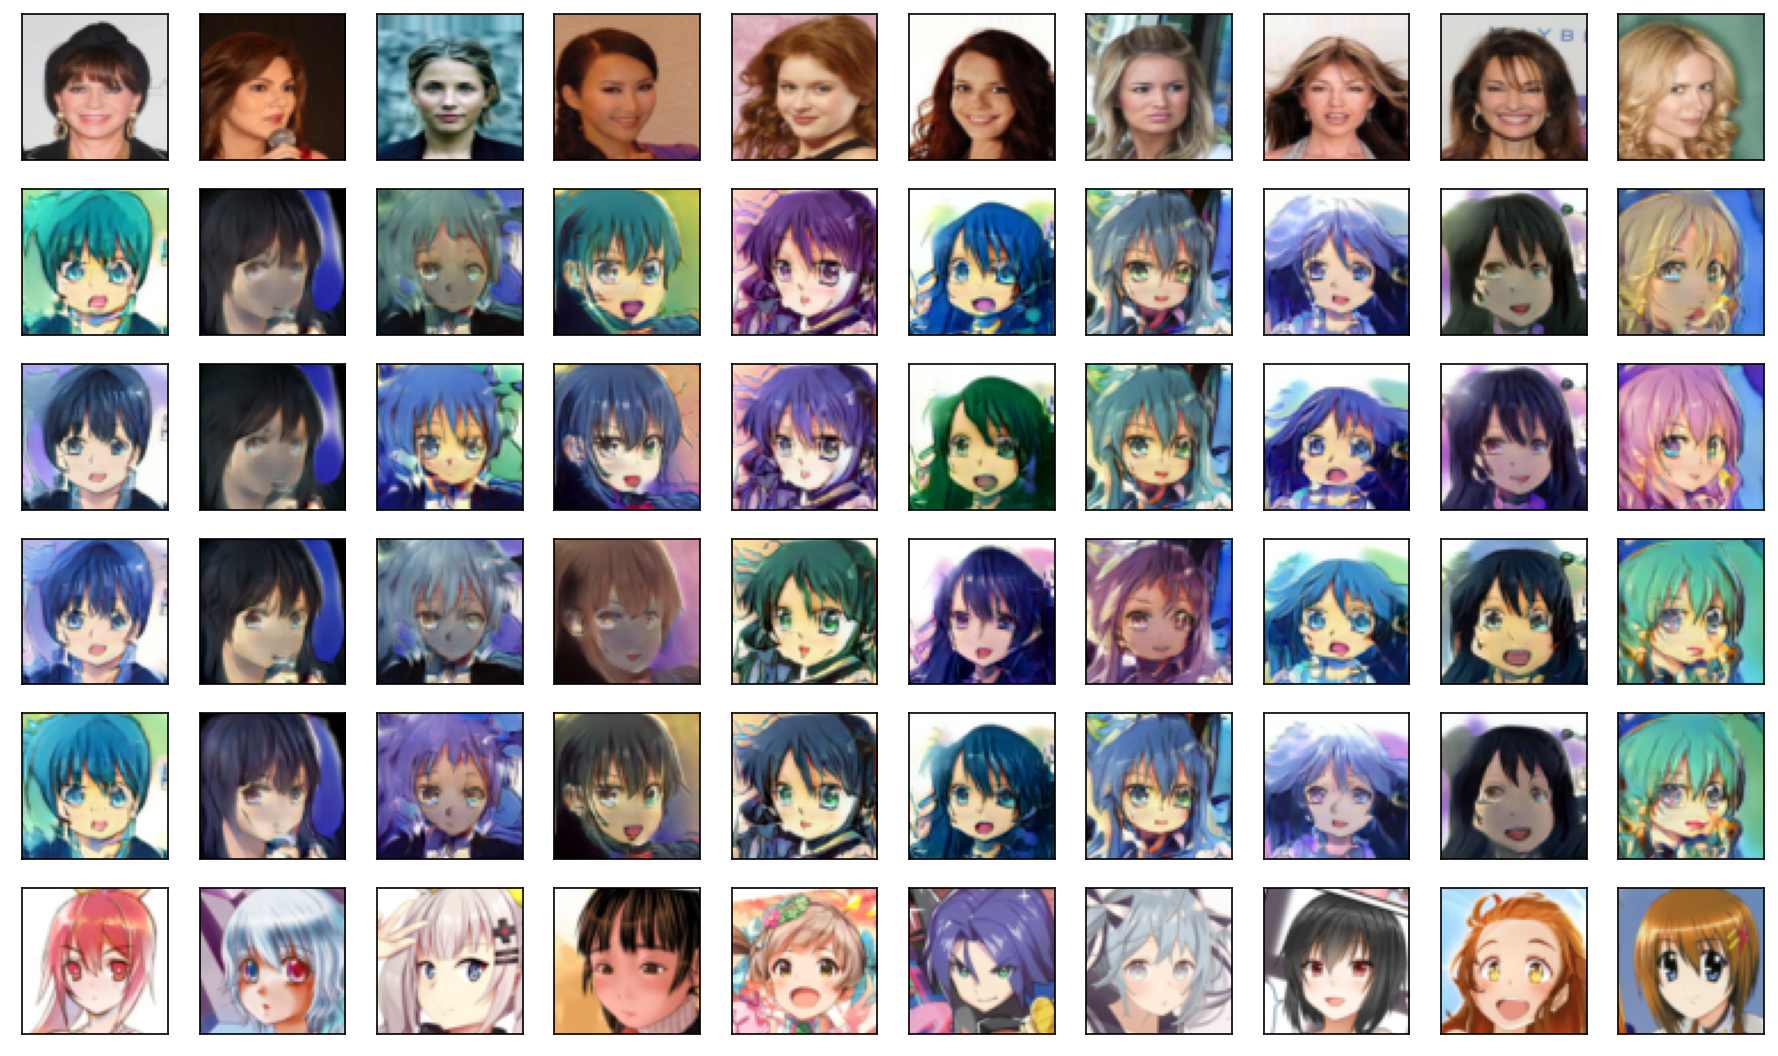

mode = test


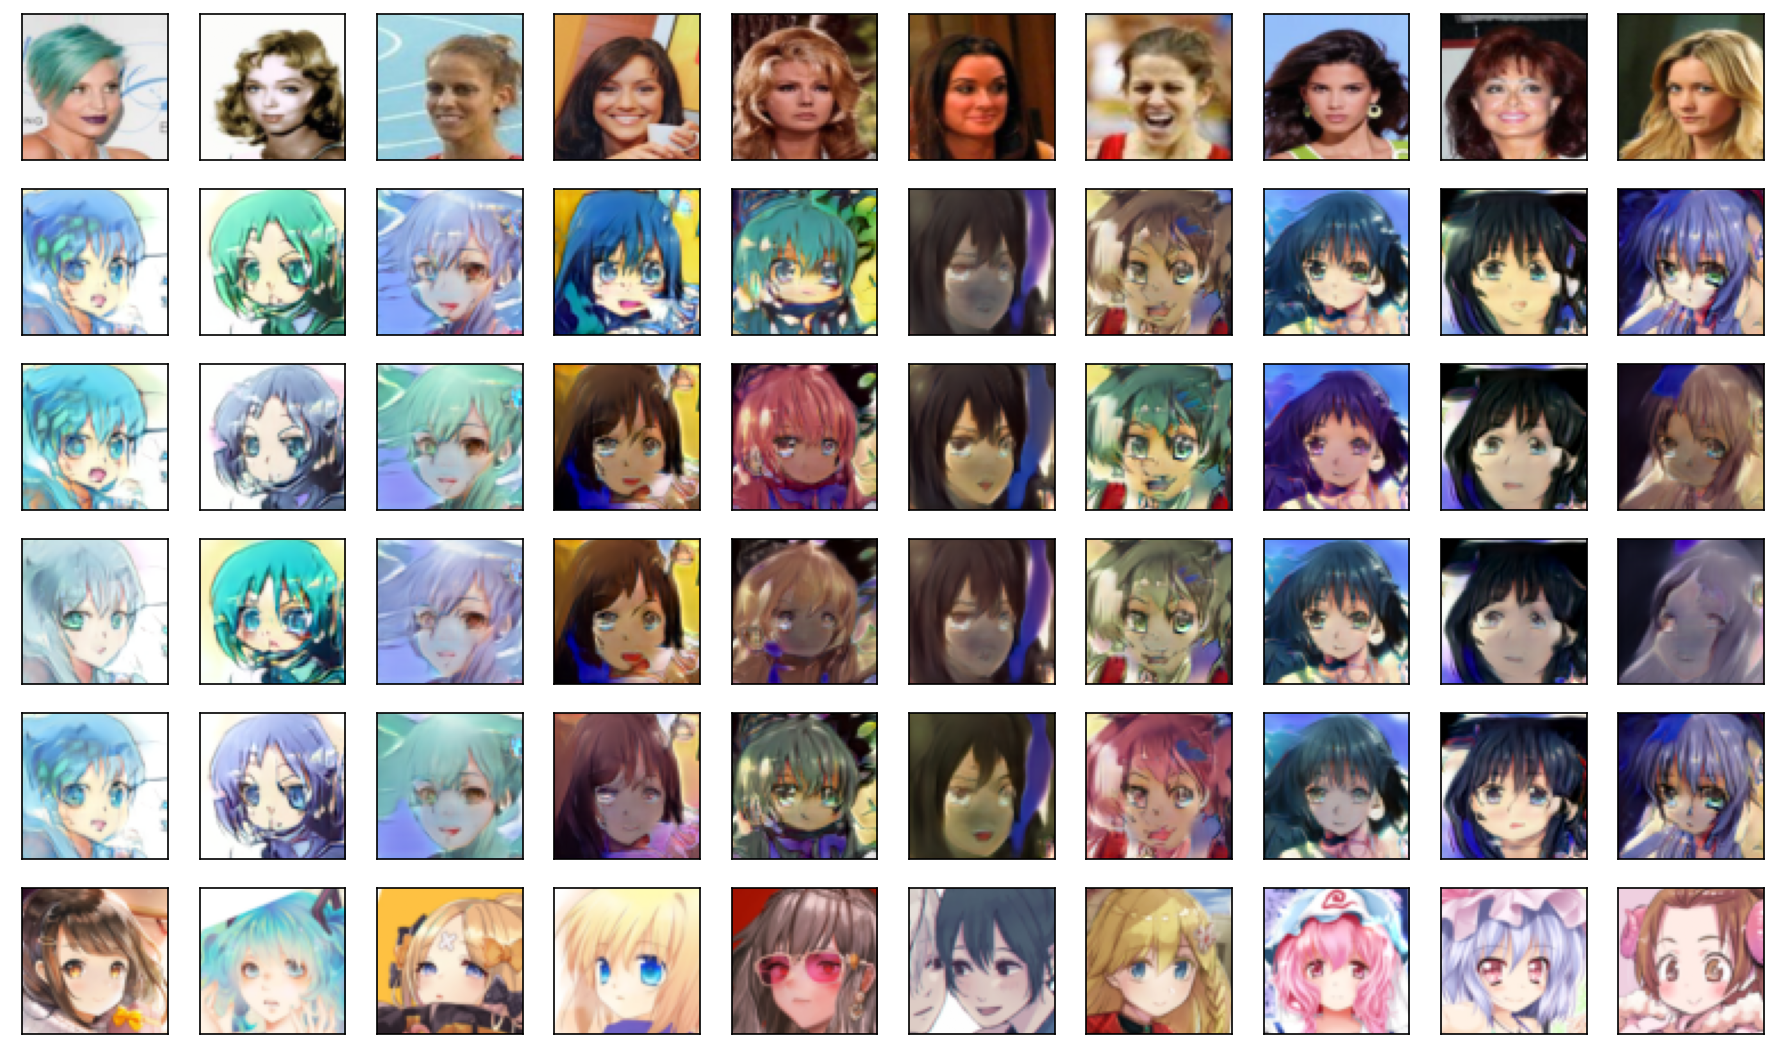

G loss = 1.3340976238250732, d loss = 1.0695298910140991, lambda id = 1.0
G loss = 1.662445306777954, d loss = 1.0324167013168335, lambda id = 1.0
G loss = 1.7146443128585815, d loss = 1.04705810546875, lambda id = 1.0
G loss = 1.750287413597107, d loss = 1.0621812343597412, lambda id = 1.0
G loss = 1.788869023323059, d loss = 0.9732567071914673, lambda id = 1.0
G loss = 1.7704721689224243, d loss = 1.062577486038208, lambda id = 1.0
G loss = 1.2982680797576904, d loss = 0.9232616424560547, lambda id = 1.0
G loss = 1.4655649662017822, d loss = 1.0812302827835083, lambda id = 1.0
G loss = 1.5068614482879639, d loss = 1.0635321140289307, lambda id = 1.0
G loss = 1.7095489501953125, d loss = 1.1151286363601685, lambda id = 1.0
Elapsed time [1 day, 5:58:39], Iteration [96011/100000], D/latent_real: [0.8402] D/latent_fake: [0.5819] D/latent_reg: [0.0844] D/ref_real: [0.3353] D/ref_fake: [0.7223] D/ref_reg: [0.0575] G/latent_adv: [1.2087] G/latent_sty: [0.0680] G/latent_ds: [0.1397] G/latent

G loss = 1.274505853652954, d loss = 1.1229251623153687, lambda id = 1.0
G loss = 1.5363974571228027, d loss = 1.0090842247009277, lambda id = 1.0
G loss = 1.7563787698745728, d loss = 0.9739751815795898, lambda id = 1.0
G loss = 1.455775260925293, d loss = 1.0297819375991821, lambda id = 1.0
G loss = 1.6128826141357422, d loss = 1.0311113595962524, lambda id = 1.0
Elapsed time [1 day, 5:59:55], Iteration [96081/100000], D/latent_real: [0.7345] D/latent_fake: [0.5349] D/latent_reg: [0.0833] D/ref_real: [0.4038] D/ref_fake: [0.5580] D/ref_reg: [0.0693] G/latent_adv: [1.1335] G/latent_sty: [0.0643] G/latent_ds: [0.1318] G/latent_cyc: [0.1889] G/ref_adv: [1.5416] G/ref_sty: [0.7198] G/ref_ds: [0.5251] G/ref_cyc: [0.1974] G/lambda_ds: [0.0392]
G loss = 1.8364893198013306, d loss = 1.0285166501998901, lambda id = 1.0
G loss = 1.7581446170806885, d loss = 1.04938805103302, lambda id = 1.0
G loss = 1.7038519382476807, d loss = 0.937868595123291, lambda id = 1.0
G loss = 1.4941070079803467, d 

Elapsed time [1 day, 6:01:11], Iteration [96151/100000], D/latent_real: [0.6040] D/latent_fake: [0.7100] D/latent_reg: [0.0717] D/ref_real: [0.5552] D/ref_fake: [0.4096] D/ref_reg: [0.0709] G/latent_adv: [0.7110] G/latent_sty: [0.0619] G/latent_ds: [0.0907] G/latent_cyc: [0.1880] G/ref_adv: [1.1245] G/ref_sty: [0.6443] G/ref_ds: [0.5049] G/ref_cyc: [0.2073] G/lambda_ds: [0.0385]
G loss = 1.1484310626983643, d loss = 1.2280867099761963, lambda id = 1.0
G loss = 1.2959792613983154, d loss = 1.2044321298599243, lambda id = 1.0
G loss = 1.5212535858154297, d loss = 0.9620518684387207, lambda id = 1.0
G loss = 1.578896403312683, d loss = 1.0548900365829468, lambda id = 1.0
G loss = 1.6512542963027954, d loss = 0.9402802586555481, lambda id = 1.0
G loss = 1.2412168979644775, d loss = 1.1567661762237549, lambda id = 1.0
G loss = 1.3282488584518433, d loss = 1.0505449771881104, lambda id = 1.0
G loss = 1.304653286933899, d loss = 1.0508742332458496, lambda id = 1.0
G loss = 1.3541817665100098,

G loss = 1.520574688911438, d loss = 0.9226170182228088, lambda id = 1.0
G loss = 1.3269288539886475, d loss = 1.1157513856887817, lambda id = 1.0
G loss = 1.1245808601379395, d loss = 1.0195578336715698, lambda id = 1.0
G loss = 1.2399721145629883, d loss = 1.2370505332946777, lambda id = 1.0
G loss = 1.1964335441589355, d loss = 1.2081643342971802, lambda id = 1.0
G loss = 1.2598686218261719, d loss = 1.123766541481018, lambda id = 1.0
G loss = 1.354102611541748, d loss = 1.0250329971313477, lambda id = 1.0
G loss = 1.3839049339294434, d loss = 1.0346319675445557, lambda id = 1.0
G loss = 1.2497111558914185, d loss = 1.0875885486602783, lambda id = 1.0
G loss = 1.5029865503311157, d loss = 1.0346320867538452, lambda id = 1.0
Elapsed time [1 day, 6:02:39], Iteration [96231/100000], D/latent_real: [0.6840] D/latent_fake: [0.6706] D/latent_reg: [0.0670] D/ref_real: [0.4766] D/ref_fake: [0.4948] D/ref_reg: [0.0632] G/latent_adv: [0.9705] G/latent_sty: [0.0646] G/latent_ds: [0.1313] G/lat

G loss = 1.5276508331298828, d loss = 1.0028494596481323, lambda id = 1.0
G loss = 1.3223079442977905, d loss = 1.0198646783828735, lambda id = 1.0
G loss = 1.204420804977417, d loss = 0.9950497150421143, lambda id = 1.0
G loss = 1.3001655340194702, d loss = 1.0581759214401245, lambda id = 1.0
G loss = 1.2118240594863892, d loss = 1.0562883615493774, lambda id = 1.0
Elapsed time [1 day, 6:03:55], Iteration [96301/100000], D/latent_real: [0.4226] D/latent_fake: [0.8142] D/latent_reg: [0.0679] D/ref_real: [0.6115] D/ref_fake: [0.3728] D/ref_reg: [0.0720] G/latent_adv: [0.7602] G/latent_sty: [0.0669] G/latent_ds: [0.1011] G/latent_cyc: [0.1872] G/ref_adv: [0.9775] G/ref_sty: [0.5160] G/ref_ds: [0.5044] G/ref_cyc: [0.2145] G/lambda_ds: [0.0370]
G loss = 1.6170402765274048, d loss = 1.0597926378250122, lambda id = 1.0
G loss = 1.245052695274353, d loss = 1.0501506328582764, lambda id = 1.0
G loss = 1.3293954133987427, d loss = 1.0319323539733887, lambda id = 1.0
G loss = 1.363818645477295, 

G loss = 1.5448758602142334, d loss = 1.0924063920974731, lambda id = 1.0
G loss = 1.6109333038330078, d loss = 1.047431230545044, lambda id = 1.0
G loss = 1.420654296875, d loss = 0.9729487895965576, lambda id = 1.0
G loss = 1.308830738067627, d loss = 0.9423650503158569, lambda id = 1.0
G loss = 1.1820273399353027, d loss = 1.0748785734176636, lambda id = 1.0
G loss = 1.4182378053665161, d loss = 1.0166858434677124, lambda id = 1.0
G loss = 1.187638521194458, d loss = 0.9968284964561462, lambda id = 1.0
G loss = 1.4051955938339233, d loss = 0.9860236048698425, lambda id = 1.0
G loss = 1.2139843702316284, d loss = 1.098177194595337, lambda id = 1.0
G loss = 1.329402208328247, d loss = 1.1118121147155762, lambda id = 1.0
Elapsed time [1 day, 6:05:22], Iteration [96381/100000], D/latent_real: [0.5208] D/latent_fake: [0.7505] D/latent_reg: [0.0699] D/ref_real: [0.5906] D/ref_fake: [0.4511] D/ref_reg: [0.0702] G/latent_adv: [0.8653] G/latent_sty: [0.0615] G/latent_ds: [0.1012] G/latent_cy

G loss = 1.4509334564208984, d loss = 1.063520073890686, lambda id = 1.0
G loss = 1.4541503190994263, d loss = 1.018478274345398, lambda id = 1.0
G loss = 1.6037681102752686, d loss = 1.0260403156280518, lambda id = 1.0
G loss = 1.458143949508667, d loss = 0.9337610006332397, lambda id = 1.0
Elapsed time [1 day, 6:06:39], Iteration [96451/100000], D/latent_real: [0.6309] D/latent_fake: [0.6106] D/latent_reg: [0.0810] D/ref_real: [0.4484] D/ref_fake: [0.4067] D/ref_reg: [0.0786] G/latent_adv: [0.9606] G/latent_sty: [0.0619] G/latent_ds: [0.1326] G/latent_cyc: [0.1994] G/ref_adv: [1.3536] G/ref_sty: [0.9400] G/ref_ds: [0.4403] G/ref_cyc: [0.2186] G/lambda_ds: [0.0355]
G loss = 1.5003676414489746, d loss = 1.0863394737243652, lambda id = 1.0
G loss = 1.554321050643921, d loss = 0.9963754415512085, lambda id = 1.0
G loss = 1.2188878059387207, d loss = 0.9341036081314087, lambda id = 1.0
G loss = 1.4079828262329102, d loss = 1.0099928379058838, lambda id = 1.0
G loss = 1.4217817783355713, d

G loss = 1.5571179389953613, d loss = 0.9405674338340759, lambda id = 1.0
G loss = 1.3160022497177124, d loss = 0.9613295793533325, lambda id = 1.0
G loss = 1.3695704936981201, d loss = 1.0388741493225098, lambda id = 1.0
G loss = 1.4763931035995483, d loss = 1.0142358541488647, lambda id = 1.0
G loss = 1.444809913635254, d loss = 1.0517247915267944, lambda id = 1.0
G loss = 1.2730374336242676, d loss = 1.0445022583007812, lambda id = 1.0
G loss = 1.230819821357727, d loss = 1.170880913734436, lambda id = 1.0
G loss = 1.210014820098877, d loss = 1.1291426420211792, lambda id = 1.0
G loss = 1.1684147119522095, d loss = 1.074705719947815, lambda id = 1.0
G loss = 1.1440839767456055, d loss = 1.1059114933013916, lambda id = 1.0
Elapsed time [1 day, 6:08:06], Iteration [96531/100000], D/latent_real: [0.5158] D/latent_fake: [1.0289] D/latent_reg: [0.0597] D/ref_real: [0.6915] D/ref_fake: [0.3562] D/ref_reg: [0.0582] G/latent_adv: [0.7022] G/latent_sty: [0.0569] G/latent_ds: [0.0764] G/laten

G loss = 1.3380905389785767, d loss = 1.0694087743759155, lambda id = 1.0
G loss = 1.3058550357818604, d loss = 1.0869213342666626, lambda id = 1.0
G loss = 1.3005067110061646, d loss = 1.1493781805038452, lambda id = 1.0
G loss = 1.3769035339355469, d loss = 1.0371962785720825, lambda id = 1.0
Elapsed time [1 day, 6:09:22], Iteration [96601/100000], D/latent_real: [0.5153] D/latent_fake: [0.7768] D/latent_reg: [0.0624] D/ref_real: [0.6076] D/ref_fake: [0.3624] D/ref_reg: [0.0672] G/latent_adv: [0.8750] G/latent_sty: [0.0651] G/latent_ds: [0.1109] G/latent_cyc: [0.1994] G/ref_adv: [1.0282] G/ref_sty: [0.7728] G/ref_ds: [0.4673] G/ref_cyc: [0.2278] G/lambda_ds: [0.0340]
G loss = 1.7556357383728027, d loss = 1.051444172859192, lambda id = 1.0
G loss = 1.734925389289856, d loss = 0.9995359182357788, lambda id = 1.0
G loss = 2.0674684047698975, d loss = 0.9371626973152161, lambda id = 1.0
G loss = 0.9935104846954346, d loss = 1.1211320161819458, lambda id = 1.0
G loss = 1.6004173755645752,

G loss = 1.5234116315841675, d loss = 1.0196255445480347, lambda id = 1.0
G loss = 1.3452327251434326, d loss = 0.9143651723861694, lambda id = 1.0
G loss = 1.6381337642669678, d loss = 0.9437365531921387, lambda id = 1.0
G loss = 1.7726571559906006, d loss = 0.974301815032959, lambda id = 1.0
G loss = 1.4568334817886353, d loss = 0.9649717807769775, lambda id = 1.0
G loss = 1.6351683139801025, d loss = 0.9729537963867188, lambda id = 1.0
G loss = 1.3643132448196411, d loss = 1.0478936433792114, lambda id = 1.0
G loss = 1.043923258781433, d loss = 1.0780072212219238, lambda id = 1.0
G loss = 1.509616732597351, d loss = 0.9640503525733948, lambda id = 1.0
G loss = 1.5086251497268677, d loss = 0.9756841063499451, lambda id = 1.0
Elapsed time [1 day, 6:10:49], Iteration [96681/100000], D/latent_real: [0.3848] D/latent_fake: [0.7625] D/latent_reg: [0.0694] D/ref_real: [0.6059] D/ref_fake: [0.2955] D/ref_reg: [0.0743] G/latent_adv: [0.9600] G/latent_sty: [0.0644] G/latent_ds: [0.1347] G/lat

G loss = 1.2336345911026, d loss = 1.0257866382598877, lambda id = 1.0
G loss = 1.2467626333236694, d loss = 1.0570080280303955, lambda id = 1.0
G loss = 1.1028531789779663, d loss = 1.082353949546814, lambda id = 1.0
G loss = 1.9367696046829224, d loss = 0.8675903081893921, lambda id = 1.0
G loss = 1.6966438293457031, d loss = 0.9669592380523682, lambda id = 1.0
Elapsed time [1 day, 6:12:06], Iteration [96751/100000], D/latent_real: [0.5205] D/latent_fake: [0.6913] D/latent_reg: [0.0540] D/ref_real: [0.5033] D/ref_fake: [0.4124] D/ref_reg: [0.0513] G/latent_adv: [1.1758] G/latent_sty: [0.0654] G/latent_ds: [0.1145] G/latent_cyc: [0.1989] G/ref_adv: [1.4075] G/ref_sty: [1.2339] G/ref_ds: [0.4472] G/ref_cyc: [0.1938] G/lambda_ds: [0.0325]
G loss = 1.2977166175842285, d loss = 1.0815740823745728, lambda id = 1.0
G loss = 1.9153389930725098, d loss = 1.0217231512069702, lambda id = 1.0
G loss = 1.507324457168579, d loss = 1.0210213661193848, lambda id = 1.0
G loss = 1.375915288925171, d l

G loss = 1.328780174255371, d loss = 1.0356814861297607, lambda id = 1.0
G loss = 1.3161982297897339, d loss = 1.0335770845413208, lambda id = 1.0
G loss = 1.2530988454818726, d loss = 0.9761457443237305, lambda id = 1.0
G loss = 1.0100680589675903, d loss = 1.050580382347107, lambda id = 1.0
G loss = 1.2056856155395508, d loss = 1.0818630456924438, lambda id = 1.0
G loss = 1.7643948793411255, d loss = 0.9462950229644775, lambda id = 1.0
G loss = 1.3396079540252686, d loss = 0.9613338112831116, lambda id = 1.0
G loss = 1.168613076210022, d loss = 1.0291659832000732, lambda id = 1.0
G loss = 1.3046321868896484, d loss = 1.0308490991592407, lambda id = 1.0
G loss = 1.2238582372665405, d loss = 1.0735673904418945, lambda id = 1.0
Elapsed time [1 day, 6:13:33], Iteration [96831/100000], D/latent_real: [0.3981] D/latent_fake: [1.0033] D/latent_reg: [0.0691] D/ref_real: [0.7028] D/ref_fake: [0.3023] D/ref_reg: [0.0685] G/latent_adv: [0.7716] G/latent_sty: [0.0586] G/latent_ds: [0.0829] G/lat

G loss = 1.554950475692749, d loss = 1.0091025829315186, lambda id = 1.0
G loss = 1.4688271284103394, d loss = 1.065960168838501, lambda id = 1.0
G loss = 1.4018241167068481, d loss = 0.956084132194519, lambda id = 1.0
G loss = 1.402309536933899, d loss = 0.9866445064544678, lambda id = 1.0
G loss = 1.1908637285232544, d loss = 1.067273497581482, lambda id = 1.0
Elapsed time [1 day, 6:14:50], Iteration [96901/100000], D/latent_real: [0.5283] D/latent_fake: [0.7979] D/latent_reg: [0.0819] D/ref_real: [0.6818] D/ref_fake: [0.3090] D/ref_reg: [0.0764] G/latent_adv: [0.7263] G/latent_sty: [0.0570] G/latent_ds: [0.1042] G/latent_cyc: [0.1897] G/ref_adv: [0.8996] G/ref_sty: [0.7878] G/ref_ds: [0.4986] G/ref_cyc: [0.1981] G/lambda_ds: [0.0310]
G loss = 1.290489912033081, d loss = 1.0782785415649414, lambda id = 1.0
G loss = 1.699366807937622, d loss = 1.0058718919754028, lambda id = 1.0
G loss = 1.4090819358825684, d loss = 1.0030468702316284, lambda id = 1.0
G loss = 1.2021510601043701, d lo

G loss = 1.7859716415405273, d loss = 1.006536841392517, lambda id = 1.0
G loss = 1.5115914344787598, d loss = 1.081662654876709, lambda id = 1.0
G loss = 1.3116941452026367, d loss = 1.221012830734253, lambda id = 1.0
G loss = 1.3381307125091553, d loss = 0.952272355556488, lambda id = 1.0
G loss = 1.5415104627609253, d loss = 0.9700546264648438, lambda id = 1.0
G loss = 1.880780816078186, d loss = 0.963390052318573, lambda id = 1.0
G loss = 1.5494807958602905, d loss = 0.9815057516098022, lambda id = 1.0
G loss = 1.6346474885940552, d loss = 0.9041283130645752, lambda id = 1.0
G loss = 1.825114130973816, d loss = 0.9038483500480652, lambda id = 1.0
G loss = 2.089343547821045, d loss = 1.061288595199585, lambda id = 1.0
Elapsed time [1 day, 6:16:17], Iteration [96981/100000], D/latent_real: [0.7391] D/latent_fake: [0.5245] D/latent_reg: [0.0875] D/ref_real: [0.3954] D/ref_fake: [0.5855] D/ref_reg: [0.0803] G/latent_adv: [1.4965] G/latent_sty: [0.0660] G/latent_ds: [0.1678] G/latent_cy

G loss = 1.6886540651321411, d loss = 1.0222595930099487, lambda id = 1.0
G loss = 1.499747395515442, d loss = 1.1581356525421143, lambda id = 1.0
G loss = 1.4338605403900146, d loss = 0.9467408657073975, lambda id = 1.0
G loss = 1.43321692943573, d loss = 0.9698216319084167, lambda id = 1.0
Elapsed time [1 day, 6:17:33], Iteration [97051/100000], D/latent_real: [0.5464] D/latent_fake: [0.6210] D/latent_reg: [0.0658] D/ref_real: [0.5089] D/ref_fake: [0.3958] D/ref_reg: [0.0651] G/latent_adv: [0.9175] G/latent_sty: [0.0677] G/latent_ds: [0.1064] G/latent_cyc: [0.2139] G/ref_adv: [1.2113] G/ref_sty: [0.6309] G/ref_ds: [0.4820] G/ref_cyc: [0.2167] G/lambda_ds: [0.0295]
G loss = 1.5677976608276367, d loss = 0.9655030369758606, lambda id = 1.0
G loss = 1.4621773958206177, d loss = 1.0136985778808594, lambda id = 1.0
G loss = 1.3784387111663818, d loss = 0.9800809025764465, lambda id = 1.0
G loss = 1.2121690511703491, d loss = 0.9975612759590149, lambda id = 1.0
G loss = 1.3476767539978027, 

G loss = 1.5311849117279053, d loss = 0.9594242572784424, lambda id = 1.0
G loss = 1.4311797618865967, d loss = 0.9984249472618103, lambda id = 1.0
G loss = 1.4510282278060913, d loss = 0.9906550645828247, lambda id = 1.0
G loss = 1.3549336194992065, d loss = 0.9853940010070801, lambda id = 1.0
G loss = 1.431766390800476, d loss = 0.9812277555465698, lambda id = 1.0
G loss = 1.8004263639450073, d loss = 0.9507836699485779, lambda id = 1.0
G loss = 1.5432409048080444, d loss = 1.111609697341919, lambda id = 1.0
G loss = 1.6559184789657593, d loss = 0.9936318397521973, lambda id = 1.0
G loss = 1.6974586248397827, d loss = 0.9677676558494568, lambda id = 1.0
G loss = 0.9989603757858276, d loss = 1.0732332468032837, lambda id = 1.0
Elapsed time [1 day, 6:19:01], Iteration [97131/100000], D/latent_real: [0.6052] D/latent_fake: [0.8203] D/latent_reg: [0.0841] D/ref_real: [0.7334] D/ref_fake: [0.2628] D/ref_reg: [0.0771] G/latent_adv: [0.5694] G/latent_sty: [0.0648] G/latent_ds: [0.0748] G/la

G loss = 1.612309455871582, d loss = 0.9832947254180908, lambda id = 1.0
G loss = 1.6194976568222046, d loss = 0.9132952690124512, lambda id = 1.0
G loss = 2.168886184692383, d loss = 0.9841747879981995, lambda id = 1.0
G loss = 1.7902600765228271, d loss = 0.9912797212600708, lambda id = 1.0
G loss = 1.517263650894165, d loss = 0.9461597800254822, lambda id = 1.0
Elapsed time [1 day, 6:20:17], Iteration [97201/100000], D/latent_real: [0.9587] D/latent_fake: [0.4691] D/latent_reg: [0.0996] D/ref_real: [0.3685] D/ref_fake: [0.5065] D/ref_reg: [0.0712] G/latent_adv: [0.9844] G/latent_sty: [0.0574] G/latent_ds: [0.1237] G/latent_cyc: [0.1934] G/ref_adv: [1.5494] G/ref_sty: [0.8195] G/ref_ds: [0.4905] G/ref_cyc: [0.1953] G/lambda_ds: [0.0280]
G loss = 1.4020553827285767, d loss = 0.899924635887146, lambda id = 1.0
G loss = 1.1973950862884521, d loss = 1.0054198503494263, lambda id = 1.0
G loss = 1.3183910846710205, d loss = 1.1665377616882324, lambda id = 1.0
G loss = 1.5900726318359375, d

Elapsed time [1 day, 6:21:33], Iteration [97271/100000], D/latent_real: [0.6770] D/latent_fake: [0.7351] D/latent_reg: [0.0779] D/ref_real: [0.4164] D/ref_fake: [0.6273] D/ref_reg: [0.0596] G/latent_adv: [1.0625] G/latent_sty: [0.0612] G/latent_ds: [0.0976] G/latent_cyc: [0.1985] G/ref_adv: [1.6637] G/ref_sty: [0.7805] G/ref_ds: [0.4948] G/ref_cyc: [0.2106] G/lambda_ds: [0.0273]
G loss = 1.4263417720794678, d loss = 0.9669533967971802, lambda id = 1.0
G loss = 1.408942461013794, d loss = 0.8752323389053345, lambda id = 1.0
G loss = 1.298068881034851, d loss = 0.9816330075263977, lambda id = 1.0
G loss = 1.1845347881317139, d loss = 1.1367398500442505, lambda id = 1.0
G loss = 1.5398221015930176, d loss = 1.0240130424499512, lambda id = 1.0
G loss = 1.102548360824585, d loss = 0.9963462948799133, lambda id = 1.0
G loss = 1.238476276397705, d loss = 1.058575987815857, lambda id = 1.0
G loss = 1.336028814315796, d loss = 0.9963860511779785, lambda id = 1.0
G loss = 1.0480639934539795, d l

G loss = 1.2259187698364258, d loss = 1.1280124187469482, lambda id = 1.0
G loss = 1.503217339515686, d loss = 1.0108741521835327, lambda id = 1.0
G loss = 1.458361268043518, d loss = 1.0434712171554565, lambda id = 1.0
G loss = 1.415921926498413, d loss = 1.0398565530776978, lambda id = 1.0
G loss = 1.5045173168182373, d loss = 0.8935434222221375, lambda id = 1.0
G loss = 1.5470547676086426, d loss = 0.8719142079353333, lambda id = 1.0
G loss = 1.3940993547439575, d loss = 0.9213079810142517, lambda id = 1.0
G loss = 1.454259991645813, d loss = 0.9391953945159912, lambda id = 1.0
G loss = 1.238309383392334, d loss = 0.9757515788078308, lambda id = 1.0
G loss = 1.4443539381027222, d loss = 0.9362090826034546, lambda id = 1.0
Elapsed time [1 day, 6:23:01], Iteration [97351/100000], D/latent_real: [0.4349] D/latent_fake: [0.7471] D/latent_reg: [0.0717] D/ref_real: [0.5246] D/ref_fake: [0.3301] D/ref_reg: [0.0815] G/latent_adv: [0.9204] G/latent_sty: [0.0687] G/latent_ds: [0.1165] G/laten

G loss = 1.1723461151123047, d loss = 0.9358385801315308, lambda id = 1.0
G loss = 1.0996475219726562, d loss = 1.0127403736114502, lambda id = 1.0
G loss = 1.3449366092681885, d loss = 1.1656321287155151, lambda id = 1.0
G loss = 1.3674802780151367, d loss = 1.034287452697754, lambda id = 1.0
G loss = 1.378216028213501, d loss = 1.0082088708877563, lambda id = 1.0
Elapsed time [1 day, 6:24:17], Iteration [97421/100000], D/latent_real: [0.5836] D/latent_fake: [0.7330] D/latent_reg: [0.0617] D/ref_real: [0.5643] D/ref_fake: [0.3869] D/ref_reg: [0.0570] G/latent_adv: [0.9079] G/latent_sty: [0.0627] G/latent_ds: [0.0930] G/latent_cyc: [0.1963] G/ref_adv: [1.2429] G/ref_sty: [0.6942] G/ref_ds: [0.4875] G/ref_cyc: [0.2170] G/lambda_ds: [0.0258]
G loss = 1.724948525428772, d loss = 0.9731748700141907, lambda id = 1.0
G loss = 1.700427532196045, d loss = 0.9976553916931152, lambda id = 1.0
G loss = 1.5017651319503784, d loss = 0.9448883533477783, lambda id = 1.0
G loss = 1.5913094282150269, d

G loss = 1.8900281190872192, d loss = 1.1366957426071167, lambda id = 1.0
G loss = 1.7912653684616089, d loss = 1.0467290878295898, lambda id = 1.0
G loss = 1.62838876247406, d loss = 1.119396448135376, lambda id = 1.0
G loss = 1.810241460800171, d loss = 1.2083237171173096, lambda id = 1.0
G loss = 1.9635823965072632, d loss = 1.102107286453247, lambda id = 1.0
G loss = 1.6881166696548462, d loss = 1.223540186882019, lambda id = 1.0
G loss = 1.6670317649841309, d loss = 1.1210778951644897, lambda id = 1.0
G loss = 1.9880601167678833, d loss = 1.0874578952789307, lambda id = 1.0
G loss = 1.6024421453475952, d loss = 1.1586377620697021, lambda id = 1.0
G loss = 1.7725591659545898, d loss = 1.0197194814682007, lambda id = 1.0
Elapsed time [1 day, 6:25:44], Iteration [97501/100000], D/latent_real: [0.7138] D/latent_fake: [0.6073] D/latent_reg: [0.0615] D/ref_real: [0.4533] D/ref_fake: [0.5108] D/ref_reg: [0.0556] G/latent_adv: [1.2216] G/latent_sty: [0.0682] G/latent_ds: [0.1064] G/latent

G loss = 1.687540888786316, d loss = 1.0496277809143066, lambda id = 1.0
G loss = 1.7975877523422241, d loss = 1.1083886623382568, lambda id = 1.0
G loss = 1.6640053987503052, d loss = 1.1047738790512085, lambda id = 1.0
G loss = 1.649383783340454, d loss = 1.1800482273101807, lambda id = 1.0
Elapsed time [1 day, 6:27:01], Iteration [97571/100000], D/latent_real: [0.7603] D/latent_fake: [0.6439] D/latent_reg: [0.0503] D/ref_real: [0.5139] D/ref_fake: [0.6212] D/ref_reg: [0.0449] G/latent_adv: [1.1305] G/latent_sty: [0.0639] G/latent_ds: [0.1385] G/latent_cyc: [0.1995] G/ref_adv: [1.0260] G/ref_sty: [0.2302] G/ref_ds: [0.1236] G/ref_cyc: [0.1876] G/lambda_ds: [0.0243]
G loss = 1.762800693511963, d loss = 1.121146559715271, lambda id = 1.0
G loss = 1.7721655368804932, d loss = 1.1911237239837646, lambda id = 1.0
G loss = 1.9154102802276611, d loss = 1.0918604135513306, lambda id = 1.0
G loss = 1.986110806465149, d loss = 1.1919265985488892, lambda id = 1.0
G loss = 1.6184829473495483, d 

G loss = 1.5970277786254883, d loss = 1.1219053268432617, lambda id = 1.0
G loss = 1.5736398696899414, d loss = 1.1618603467941284, lambda id = 1.0
G loss = 1.5963053703308105, d loss = 1.0926204919815063, lambda id = 1.0
G loss = 1.697793960571289, d loss = 1.1411710977554321, lambda id = 1.0
G loss = 1.6382641792297363, d loss = 1.0714868307113647, lambda id = 1.0
G loss = 1.8513545989990234, d loss = 1.0820826292037964, lambda id = 1.0
G loss = 1.789070725440979, d loss = 1.061406135559082, lambda id = 1.0
G loss = 1.999471664428711, d loss = 1.052687644958496, lambda id = 1.0
G loss = 1.8391004800796509, d loss = 1.0709583759307861, lambda id = 1.0
G loss = 1.7361433506011963, d loss = 0.9668393135070801, lambda id = 1.0
Elapsed time [1 day, 6:28:29], Iteration [97651/100000], D/latent_real: [0.7583] D/latent_fake: [0.4624] D/latent_reg: [0.0586] D/ref_real: [0.4076] D/ref_fake: [0.5072] D/ref_reg: [0.0520] G/latent_adv: [1.1510] G/latent_sty: [0.0779] G/latent_ds: [0.1328] G/laten

G loss = 1.693084716796875, d loss = 1.0599290132522583, lambda id = 1.0
G loss = 1.9485341310501099, d loss = 0.9378052949905396, lambda id = 1.0
G loss = 2.2025744915008545, d loss = 1.1090514659881592, lambda id = 1.0
G loss = 1.3331942558288574, d loss = 1.1129430532455444, lambda id = 1.0
G loss = 1.3447155952453613, d loss = 0.960656464099884, lambda id = 1.0
Elapsed time [1 day, 6:29:45], Iteration [97721/100000], D/latent_real: [0.5931] D/latent_fake: [0.5934] D/latent_reg: [0.0652] D/ref_real: [0.4486] D/ref_fake: [0.4475] D/ref_reg: [0.0646] G/latent_adv: [0.9267] G/latent_sty: [0.0618] G/latent_ds: [0.0752] G/latent_cyc: [0.1676] G/ref_adv: [1.0500] G/ref_sty: [0.4930] G/ref_ds: [0.3700] G/ref_cyc: [0.1773] G/lambda_ds: [0.0228]
G loss = 1.1976133584976196, d loss = 1.0955077409744263, lambda id = 1.0
G loss = 2.070636749267578, d loss = 1.0390491485595703, lambda id = 1.0
G loss = 1.7921624183654785, d loss = 1.0578746795654297, lambda id = 1.0
G loss = 1.6584080457687378, 

Elapsed time [1 day, 6:31:02], Iteration [97791/100000], D/latent_real: [0.5543] D/latent_fake: [0.6766] D/latent_reg: [0.0662] D/ref_real: [0.5498] D/ref_fake: [0.4441] D/ref_reg: [0.0672] G/latent_adv: [0.9557] G/latent_sty: [0.0609] G/latent_ds: [0.1029] G/latent_cyc: [0.1764] G/ref_adv: [1.1448] G/ref_sty: [0.5064] G/ref_ds: [0.5019] G/ref_cyc: [0.2227] G/lambda_ds: [0.0221]
G loss = 1.5134903192520142, d loss = 1.0682132244110107, lambda id = 1.0
G loss = 1.5316383838653564, d loss = 1.0371369123458862, lambda id = 1.0
G loss = 1.8391693830490112, d loss = 1.0792111158370972, lambda id = 1.0
G loss = 1.3187100887298584, d loss = 1.0680886507034302, lambda id = 1.0
G loss = 1.6825079917907715, d loss = 1.100556492805481, lambda id = 1.0
G loss = 1.7810662984848022, d loss = 0.9144617915153503, lambda id = 1.0
G loss = 1.509057641029358, d loss = 1.0063273906707764, lambda id = 1.0
G loss = 1.7730610370635986, d loss = 1.2237178087234497, lambda id = 1.0
G loss = 1.5374360084533691,

G loss = 1.3223681449890137, d loss = 0.9807778000831604, lambda id = 1.0
G loss = 1.7288262844085693, d loss = 1.1689728498458862, lambda id = 1.0
G loss = 1.5691362619400024, d loss = 1.0633316040039062, lambda id = 1.0
G loss = 1.437105655670166, d loss = 1.0866936445236206, lambda id = 1.0
G loss = 1.7562079429626465, d loss = 1.0396654605865479, lambda id = 1.0
G loss = 2.0796523094177246, d loss = 1.2448748350143433, lambda id = 1.0
G loss = 1.7258262634277344, d loss = 0.945304811000824, lambda id = 1.0
G loss = 1.3967797756195068, d loss = 1.1243469715118408, lambda id = 1.0
G loss = 1.6709561347961426, d loss = 0.9305333495140076, lambda id = 1.0
G loss = 1.9694879055023193, d loss = 0.9551026225090027, lambda id = 1.0
Elapsed time [1 day, 6:32:29], Iteration [97871/100000], D/latent_real: [0.5901] D/latent_fake: [0.4767] D/latent_reg: [0.0618] D/ref_real: [0.3798] D/ref_fake: [0.5119] D/ref_reg: [0.0634] G/latent_adv: [1.4345] G/latent_sty: [0.0698] G/latent_ds: [0.1628] G/la

G loss = 1.55238676071167, d loss = 1.009265661239624, lambda id = 1.0
G loss = 1.4033784866333008, d loss = 1.0508216619491577, lambda id = 1.0
G loss = 1.7325478792190552, d loss = 1.0690606832504272, lambda id = 1.0
G loss = 1.551249623298645, d loss = 1.0937578678131104, lambda id = 1.0
Elapsed time [1 day, 6:33:45], Iteration [97941/100000], D/latent_real: [0.9198] D/latent_fake: [0.5522] D/latent_reg: [0.0718] D/ref_real: [0.4473] D/ref_fake: [0.5914] D/ref_reg: [0.0550] G/latent_adv: [1.0571] G/latent_sty: [0.0589] G/latent_ds: [0.1053] G/latent_cyc: [0.1941] G/ref_adv: [1.2958] G/ref_sty: [0.5194] G/ref_ds: [0.5222] G/ref_cyc: [0.1988] G/lambda_ds: [0.0206]
G loss = 1.2271884679794312, d loss = 1.1607029438018799, lambda id = 1.0
G loss = 1.6919384002685547, d loss = 1.083508014678955, lambda id = 1.0
G loss = 1.4248993396759033, d loss = 1.0158355236053467, lambda id = 1.0
G loss = 1.456770658493042, d loss = 1.1217516660690308, lambda id = 1.0
G loss = 1.7258906364440918, d l

G loss = 1.589629054069519, d loss = 0.895000159740448, lambda id = 1.0
G loss = 1.9462478160858154, d loss = 1.0395169258117676, lambda id = 1.0
G loss = 1.679664969444275, d loss = 0.9657519459724426, lambda id = 1.0
G loss = 1.4822373390197754, d loss = 0.9531071782112122, lambda id = 1.0
G loss = 1.1165217161178589, d loss = 1.1075167655944824, lambda id = 1.0
G loss = 1.3260860443115234, d loss = 1.0884233713150024, lambda id = 1.0
G loss = 1.0960789918899536, d loss = 1.132303237915039, lambda id = 1.0
G loss = 1.5231537818908691, d loss = 1.1036773920059204, lambda id = 1.0
G loss = 1.0803110599517822, d loss = 1.1765432357788086, lambda id = 1.0
G loss = 1.572695255279541, d loss = 0.971608579158783, lambda id = 1.0
Elapsed time [1 day, 6:35:13], Iteration [98021/100000], D/latent_real: [0.5653] D/latent_fake: [0.7046] D/latent_reg: [0.0683] D/ref_real: [0.5381] D/ref_fake: [0.3712] D/ref_reg: [0.0623] G/latent_adv: [1.0723] G/latent_sty: [0.0699] G/latent_ds: [0.1193] G/latent

G loss = 1.3377807140350342, d loss = 1.0737334489822388, lambda id = 1.0
G loss = 1.1300064325332642, d loss = 1.103448748588562, lambda id = 1.0
G loss = 1.2638204097747803, d loss = 1.1091437339782715, lambda id = 1.0
G loss = 1.1307169198989868, d loss = 1.0557605028152466, lambda id = 1.0
Elapsed time [1 day, 6:36:29], Iteration [98091/100000], D/latent_real: [0.5155] D/latent_fake: [0.7859] D/latent_reg: [0.0546] D/ref_real: [0.6095] D/ref_fake: [0.3844] D/ref_reg: [0.0619] G/latent_adv: [0.7125] G/latent_sty: [0.0597] G/latent_ds: [0.0810] G/latent_cyc: [0.1772] G/ref_adv: [1.0386] G/ref_sty: [0.6677] G/ref_ds: [0.4978] G/ref_cyc: [0.2020] G/lambda_ds: [0.0191]
G loss = 1.1779768466949463, d loss = 1.098680019378662, lambda id = 1.0
G loss = 1.6392555236816406, d loss = 1.0357344150543213, lambda id = 1.0
G loss = 1.1459466218948364, d loss = 1.0525938272476196, lambda id = 1.0
G loss = 1.2972725629806519, d loss = 1.005435585975647, lambda id = 1.0
G loss = 1.7392029762268066, 

G loss = 1.7866131067276, d loss = 1.0663355588912964, lambda id = 1.0
G loss = 1.626873254776001, d loss = 1.0799715518951416, lambda id = 1.0
G loss = 1.3920271396636963, d loss = 1.0903570652008057, lambda id = 1.0
G loss = 1.6688315868377686, d loss = 1.0461571216583252, lambda id = 1.0
G loss = 1.333495855331421, d loss = 1.0925629138946533, lambda id = 1.0
G loss = 1.4405510425567627, d loss = 0.9896320700645447, lambda id = 1.0
G loss = 1.1220431327819824, d loss = 1.0923731327056885, lambda id = 1.0
G loss = 1.1237785816192627, d loss = 1.0373082160949707, lambda id = 1.0
G loss = 1.491231918334961, d loss = 1.0594937801361084, lambda id = 1.0
G loss = 1.3553725481033325, d loss = 1.008479356765747, lambda id = 1.0
Elapsed time [1 day, 6:37:57], Iteration [98171/100000], D/latent_real: [0.4975] D/latent_fake: [0.7584] D/latent_reg: [0.0691] D/ref_real: [0.5430] D/ref_fake: [0.3927] D/ref_reg: [0.0727] G/latent_adv: [0.9012] G/latent_sty: [0.0662] G/latent_ds: [0.1008] G/latent_

G loss = 1.294339656829834, d loss = 0.8967533707618713, lambda id = 1.0
G loss = 1.3854973316192627, d loss = 0.9480795860290527, lambda id = 1.0
G loss = 1.1729940176010132, d loss = 1.1899198293685913, lambda id = 1.0
G loss = 1.4735267162322998, d loss = 1.1060253381729126, lambda id = 1.0
Elapsed time [1 day, 6:39:13], Iteration [98241/100000], D/latent_real: [0.4651] D/latent_fake: [0.7748] D/latent_reg: [0.0574] D/ref_real: [0.5479] D/ref_fake: [0.4918] D/ref_reg: [0.0664] G/latent_adv: [0.9967] G/latent_sty: [0.0564] G/latent_ds: [0.1059] G/latent_cyc: [0.2005] G/ref_adv: [1.2544] G/ref_sty: [0.4350] G/ref_ds: [0.4917] G/ref_cyc: [0.2146] G/lambda_ds: [0.0176]
G loss = 1.2138060331344604, d loss = 1.0574607849121094, lambda id = 1.0
G loss = 1.2638828754425049, d loss = 1.136438012123108, lambda id = 1.0
G loss = 1.4792892932891846, d loss = 1.0528309345245361, lambda id = 1.0
G loss = 1.4384572505950928, d loss = 1.044950246810913, lambda id = 1.0
G loss = 1.1499686241149902, 

G loss = 1.3496649265289307, d loss = 1.2203466892242432, lambda id = 1.0
G loss = 1.3385319709777832, d loss = 1.0588200092315674, lambda id = 1.0
G loss = 1.536716103553772, d loss = 1.0277303457260132, lambda id = 1.0
G loss = 1.4267590045928955, d loss = 1.0769580602645874, lambda id = 1.0
G loss = 1.4297713041305542, d loss = 0.9544529914855957, lambda id = 1.0
G loss = 1.0651605129241943, d loss = 1.1336263418197632, lambda id = 1.0
G loss = 1.2736189365386963, d loss = 1.0908119678497314, lambda id = 1.0
G loss = 1.4992221593856812, d loss = 1.1136424541473389, lambda id = 1.0
G loss = 1.7566003799438477, d loss = 0.9577155709266663, lambda id = 1.0
G loss = 1.6195893287658691, d loss = 0.9133189916610718, lambda id = 1.0
Elapsed time [1 day, 6:40:41], Iteration [98321/100000], D/latent_real: [0.6298] D/latent_fake: [0.5674] D/latent_reg: [0.0679] D/ref_real: [0.4162] D/ref_fake: [0.4340] D/ref_reg: [0.0631] G/latent_adv: [1.0643] G/latent_sty: [0.0516] G/latent_ds: [0.1379] G/l

G loss = 1.186903476715088, d loss = 0.9347937703132629, lambda id = 1.0
G loss = 1.298723816871643, d loss = 1.1288061141967773, lambda id = 1.0
G loss = 1.4649691581726074, d loss = 1.003520131111145, lambda id = 1.0
G loss = 1.568483829498291, d loss = 0.9691171646118164, lambda id = 1.0
G loss = 1.3961743116378784, d loss = 0.9708811640739441, lambda id = 1.0
Elapsed time [1 day, 6:41:57], Iteration [98391/100000], D/latent_real: [0.7287] D/latent_fake: [0.7010] D/latent_reg: [0.0780] D/ref_real: [0.4797] D/ref_fake: [0.4279] D/ref_reg: [0.0634] G/latent_adv: [0.8955] G/latent_sty: [0.0679] G/latent_ds: [0.1092] G/latent_cyc: [0.1853] G/ref_adv: [1.3518] G/ref_sty: [0.9895] G/ref_ds: [0.5460] G/ref_cyc: [0.2065] G/lambda_ds: [0.0161]
G loss = 1.3974204063415527, d loss = 0.9242106080055237, lambda id = 1.0
G loss = 1.355994462966919, d loss = 1.0089079141616821, lambda id = 1.0
G loss = 1.799692153930664, d loss = 0.9848867654800415, lambda id = 1.0
G loss = 1.3823752403259277, d l

G loss = 1.341179370880127, d loss = 1.0509597063064575, lambda id = 1.0
G loss = 1.4119081497192383, d loss = 0.9509919285774231, lambda id = 1.0
G loss = 1.298356056213379, d loss = 0.9978315234184265, lambda id = 1.0
G loss = 1.3446403741836548, d loss = 1.1285994052886963, lambda id = 1.0
G loss = 1.5228042602539062, d loss = 1.0369664430618286, lambda id = 1.0
G loss = 1.0800085067749023, d loss = 1.0824706554412842, lambda id = 1.0
G loss = 1.3102622032165527, d loss = 0.9519454836845398, lambda id = 1.0
G loss = 1.390683650970459, d loss = 1.1224089860916138, lambda id = 1.0
G loss = 1.4072901010513306, d loss = 1.0666282176971436, lambda id = 1.0
G loss = 1.2554817199707031, d loss = 1.0005462169647217, lambda id = 1.0
Elapsed time [1 day, 6:43:25], Iteration [98471/100000], D/latent_real: [0.5434] D/latent_fake: [0.7946] D/latent_reg: [0.0671] D/ref_real: [0.5922] D/ref_fake: [0.3447] D/ref_reg: [0.0636] G/latent_adv: [0.7700] G/latent_sty: [0.0629] G/latent_ds: [0.0831] G/lat

G loss = 1.130716323852539, d loss = 1.0990934371948242, lambda id = 1.0
G loss = 1.3766001462936401, d loss = 1.043656349182129, lambda id = 1.0
G loss = 1.5305742025375366, d loss = 1.1389504671096802, lambda id = 1.0
G loss = 1.709732174873352, d loss = 0.9039641618728638, lambda id = 1.0
G loss = 1.2849452495574951, d loss = 0.9811620116233826, lambda id = 1.0
Elapsed time [1 day, 6:44:41], Iteration [98541/100000], D/latent_real: [0.6598] D/latent_fake: [0.6847] D/latent_reg: [0.0785] D/ref_real: [0.4922] D/ref_fake: [0.4174] D/ref_reg: [0.0716] G/latent_adv: [0.8088] G/latent_sty: [0.0592] G/latent_ds: [0.1011] G/latent_cyc: [0.1920] G/ref_adv: [1.3710] G/ref_sty: [0.7753] G/ref_ds: [0.4018] G/ref_cyc: [0.2019] G/lambda_ds: [0.0146]
G loss = 1.838958501815796, d loss = 0.9591798782348633, lambda id = 1.0
G loss = 1.5496175289154053, d loss = 0.9828382134437561, lambda id = 1.0
G loss = 0.8483390212059021, d loss = 1.057457447052002, lambda id = 1.0
G loss = 1.2202246189117432, d 

G loss = 1.6263158321380615, d loss = 0.9848495721817017, lambda id = 1.0
G loss = 1.4140582084655762, d loss = 1.0102788209915161, lambda id = 1.0
G loss = 1.718635082244873, d loss = 0.9972105026245117, lambda id = 1.0
G loss = 1.9342260360717773, d loss = 1.0872242450714111, lambda id = 1.0
G loss = 1.4209370613098145, d loss = 1.0716784000396729, lambda id = 1.0
G loss = 1.234039306640625, d loss = 1.0056705474853516, lambda id = 1.0
G loss = 1.103827714920044, d loss = 1.0685594081878662, lambda id = 1.0
G loss = 1.4308886528015137, d loss = 1.0450820922851562, lambda id = 1.0
G loss = 1.2335073947906494, d loss = 0.9977771043777466, lambda id = 1.0
G loss = 1.424306035041809, d loss = 0.9416830539703369, lambda id = 1.0
Elapsed time [1 day, 6:46:09], Iteration [98621/100000], D/latent_real: [0.5438] D/latent_fake: [0.6725] D/latent_reg: [0.0736] D/ref_real: [0.4986] D/ref_fake: [0.3692] D/ref_reg: [0.0739] G/latent_adv: [0.9269] G/latent_sty: [0.0630] G/latent_ds: [0.1294] G/late

G loss = 1.7261416912078857, d loss = 0.93787682056427, lambda id = 1.0
G loss = 1.4758741855621338, d loss = 0.8949283361434937, lambda id = 1.0
G loss = 1.4651057720184326, d loss = 0.8639348745346069, lambda id = 1.0
G loss = 1.1173794269561768, d loss = 1.0606850385665894, lambda id = 1.0
Elapsed time [1 day, 6:47:25], Iteration [98691/100000], D/latent_real: [0.4877] D/latent_fake: [0.8634] D/latent_reg: [0.0795] D/ref_real: [0.6878] D/ref_fake: [0.2928] D/ref_reg: [0.0801] G/latent_adv: [0.6193] G/latent_sty: [0.0685] G/latent_ds: [0.0827] G/latent_cyc: [0.2141] G/ref_adv: [0.9782] G/ref_sty: [1.9385] G/ref_ds: [0.5024] G/ref_cyc: [0.2298] G/lambda_ds: [0.0131]
G loss = 1.621588945388794, d loss = 1.0330628156661987, lambda id = 1.0
G loss = 1.5228196382522583, d loss = 0.9577909111976624, lambda id = 1.0
G loss = 1.2523046731948853, d loss = 1.0039044618606567, lambda id = 1.0
G loss = 1.2025463581085205, d loss = 1.0826653242111206, lambda id = 1.0
G loss = 1.3115779161453247, 

G loss = 1.5084543228149414, d loss = 1.1212786436080933, lambda id = 1.0
G loss = 1.187738060951233, d loss = 1.0657631158828735, lambda id = 1.0
G loss = 1.5316741466522217, d loss = 0.9825668334960938, lambda id = 1.0
G loss = 1.1521263122558594, d loss = 1.0455684661865234, lambda id = 1.0
G loss = 1.4735862016677856, d loss = 0.9064298868179321, lambda id = 1.0
G loss = 1.3898144960403442, d loss = 0.9792108535766602, lambda id = 1.0
G loss = 1.231648325920105, d loss = 1.0175410509109497, lambda id = 1.0
G loss = 1.2614169120788574, d loss = 0.9602302312850952, lambda id = 1.0
G loss = 1.2851245403289795, d loss = 1.0068304538726807, lambda id = 1.0
G loss = 1.451187252998352, d loss = 0.9972413778305054, lambda id = 1.0
Elapsed time [1 day, 6:48:53], Iteration [98771/100000], D/latent_real: [0.5001] D/latent_fake: [0.7535] D/latent_reg: [0.0741] D/ref_real: [0.5836] D/ref_fake: [0.3376] D/ref_reg: [0.0760] G/latent_adv: [0.9282] G/latent_sty: [0.0576] G/latent_ds: [0.1248] G/lat

G loss = 1.3073495626449585, d loss = 1.142783522605896, lambda id = 1.0
G loss = 1.3788942098617554, d loss = 0.9840490221977234, lambda id = 1.0
G loss = 1.2101408243179321, d loss = 1.0703308582305908, lambda id = 1.0
G loss = 1.4676227569580078, d loss = 0.8696988821029663, lambda id = 1.0
Elapsed time [1 day, 6:50:09], Iteration [98841/100000], D/latent_real: [0.5518] D/latent_fake: [0.7051] D/latent_reg: [0.0815] D/ref_real: [0.4493] D/ref_fake: [0.3383] D/ref_reg: [0.0821] G/latent_adv: [0.9045] G/latent_sty: [0.0876] G/latent_ds: [0.1284] G/latent_cyc: [0.2079] G/ref_adv: [1.3690] G/ref_sty: [1.8157] G/ref_ds: [0.5422] G/ref_cyc: [0.2499] G/lambda_ds: [0.0116]
G loss = 1.319393277168274, d loss = 0.9231739640235901, lambda id = 1.0
G loss = 1.181409478187561, d loss = 1.2868620157241821, lambda id = 1.0
G loss = 1.5314887762069702, d loss = 1.1719443798065186, lambda id = 1.0
G loss = 1.3987083435058594, d loss = 1.004115343093872, lambda id = 1.0
G loss = 1.6959620714187622, d

G loss = 1.1693068742752075, d loss = 1.0593281984329224, lambda id = 1.0
G loss = 1.3292605876922607, d loss = 1.1272672414779663, lambda id = 1.0
G loss = 1.4523638486862183, d loss = 0.9518734812736511, lambda id = 1.0
G loss = 1.4334818124771118, d loss = 1.0029852390289307, lambda id = 1.0
G loss = 1.3322356939315796, d loss = 0.937484085559845, lambda id = 1.0
G loss = 1.6540746688842773, d loss = 0.8241137266159058, lambda id = 1.0
G loss = 1.053575038909912, d loss = 1.0829854011535645, lambda id = 1.0
G loss = 1.3372523784637451, d loss = 1.0241625308990479, lambda id = 1.0
G loss = 1.4263783693313599, d loss = 1.009556531906128, lambda id = 1.0
G loss = 1.7194266319274902, d loss = 0.8475252985954285, lambda id = 1.0
Elapsed time [1 day, 6:51:37], Iteration [98921/100000], D/latent_real: [0.4809] D/latent_fake: [0.6848] D/latent_reg: [0.0764] D/ref_real: [0.3993] D/ref_fake: [0.3789] D/ref_reg: [0.0694] G/latent_adv: [1.2073] G/latent_sty: [0.0622] G/latent_ds: [0.1478] G/lat

G loss = 1.2092773914337158, d loss = 1.0768640041351318, lambda id = 1.0
G loss = 1.3547303676605225, d loss = 1.0686366558074951, lambda id = 1.0
G loss = 1.5151033401489258, d loss = 1.0124218463897705, lambda id = 1.0
G loss = 1.0673247575759888, d loss = 0.9552468061447144, lambda id = 1.0
G loss = 1.4984140396118164, d loss = 0.9583262801170349, lambda id = 1.0
Elapsed time [1 day, 6:52:53], Iteration [98991/100000], D/latent_real: [0.5876] D/latent_fake: [0.7055] D/latent_reg: [0.0756] D/ref_real: [0.5033] D/ref_fake: [0.3803] D/ref_reg: [0.0747] G/latent_adv: [0.9872] G/latent_sty: [0.0596] G/latent_ds: [0.1038] G/latent_cyc: [0.1864] G/ref_adv: [1.4575] G/ref_sty: [0.8900] G/ref_ds: [0.4643] G/ref_cyc: [0.1895] G/lambda_ds: [0.0101]
G loss = 1.159860372543335, d loss = 1.0325385332107544, lambda id = 1.0
G loss = 1.2277356386184692, d loss = 1.0699971914291382, lambda id = 1.0
G loss = 1.5786417722702026, d loss = 1.0528594255447388, lambda id = 1.0
G loss = 1.2048554420471191

Elapsed time [1 day, 6:54:10], Iteration [99061/100000], D/latent_real: [0.5598] D/latent_fake: [0.7672] D/latent_reg: [0.0744] D/ref_real: [0.5068] D/ref_fake: [0.4070] D/ref_reg: [0.0684] G/latent_adv: [0.9442] G/latent_sty: [0.0652] G/latent_ds: [0.1063] G/latent_cyc: [0.1937] G/ref_adv: [1.3090] G/ref_sty: [0.8473] G/ref_ds: [0.5078] G/ref_cyc: [0.1999] G/lambda_ds: [0.0094]
G loss = 1.5282114744186401, d loss = 1.0427573919296265, lambda id = 1.0
G loss = 1.9483551979064941, d loss = 0.778986930847168, lambda id = 1.0
G loss = 1.3789196014404297, d loss = 0.9451668858528137, lambda id = 1.0
G loss = 1.622180700302124, d loss = 0.8180253505706787, lambda id = 1.0
G loss = 1.1686800718307495, d loss = 0.9061539173126221, lambda id = 1.0
G loss = 1.2774064540863037, d loss = 1.029198169708252, lambda id = 1.0
G loss = 1.5032410621643066, d loss = 1.0138131380081177, lambda id = 1.0
G loss = 1.440317988395691, d loss = 0.9650635719299316, lambda id = 1.0
G loss = 2.0130774974823, d lo

G loss = 1.703747272491455, d loss = 0.9218005537986755, lambda id = 1.0
G loss = 1.9575614929199219, d loss = 1.0301250219345093, lambda id = 1.0
G loss = 2.2087128162384033, d loss = 0.7441243529319763, lambda id = 1.0
G loss = 1.8347430229187012, d loss = 0.8580717444419861, lambda id = 1.0
G loss = 1.4651429653167725, d loss = 0.9905579090118408, lambda id = 1.0
G loss = 1.5867738723754883, d loss = 1.088430404663086, lambda id = 1.0
G loss = 1.3160821199417114, d loss = 0.9563776850700378, lambda id = 1.0
G loss = 1.3068662881851196, d loss = 0.913029134273529, lambda id = 1.0
G loss = 1.3747375011444092, d loss = 1.0163466930389404, lambda id = 1.0
G loss = 1.5660839080810547, d loss = 0.9073702096939087, lambda id = 1.0
Elapsed time [1 day, 6:55:37], Iteration [99141/100000], D/latent_real: [0.4887] D/latent_fake: [0.6877] D/latent_reg: [0.0765] D/ref_real: [0.5073] D/ref_fake: [0.3272] D/ref_reg: [0.0729] G/latent_adv: [1.0830] G/latent_sty: [0.0560] G/latent_ds: [0.1344] G/lat

G loss = 1.2031018733978271, d loss = 1.1126463413238525, lambda id = 1.0
G loss = 1.650909185409546, d loss = 0.9779083132743835, lambda id = 1.0
G loss = 1.4149749279022217, d loss = 1.054385781288147, lambda id = 1.0
G loss = 1.2163814306259155, d loss = 1.0095549821853638, lambda id = 1.0
Elapsed time [1 day, 6:56:54], Iteration [99211/100000], D/latent_real: [0.6145] D/latent_fake: [0.6625] D/latent_reg: [0.0763] D/ref_real: [0.5215] D/ref_fake: [0.4168] D/ref_reg: [0.0713] G/latent_adv: [0.7843] G/latent_sty: [0.0563] G/latent_ds: [0.0833] G/latent_cyc: [0.1660] G/ref_adv: [1.1825] G/ref_sty: [1.2692] G/ref_ds: [0.4355] G/ref_cyc: [0.1863] G/lambda_ds: [0.0079]
G loss = 1.3433822393417358, d loss = 1.0318224430084229, lambda id = 1.0
G loss = 1.7876477241516113, d loss = 0.994640052318573, lambda id = 1.0
G loss = 1.1912566423416138, d loss = 0.992493748664856, lambda id = 1.0
G loss = 1.261275291442871, d loss = 1.1889897584915161, lambda id = 1.0
G loss = 1.6402841806411743, d 

G loss = 1.271666407585144, d loss = 1.0899219512939453, lambda id = 1.0
G loss = 1.4990710020065308, d loss = 0.9687104225158691, lambda id = 1.0
G loss = 1.2071411609649658, d loss = 0.8626183271408081, lambda id = 1.0
G loss = 1.1127443313598633, d loss = 1.0455307960510254, lambda id = 1.0
G loss = 1.4105684757232666, d loss = 1.0432713031768799, lambda id = 1.0
G loss = 1.125351071357727, d loss = 0.9251031279563904, lambda id = 1.0
G loss = 1.4564194679260254, d loss = 0.9372516870498657, lambda id = 1.0
G loss = 1.2747342586517334, d loss = 0.977347731590271, lambda id = 1.0
G loss = 1.294451117515564, d loss = 1.0060633420944214, lambda id = 1.0
G loss = 1.2354018688201904, d loss = 1.0413262844085693, lambda id = 1.0
Elapsed time [1 day, 6:58:21], Iteration [99291/100000], D/latent_real: [0.3775] D/latent_fake: [0.8791] D/latent_reg: [0.0723] D/ref_real: [0.7708] D/ref_fake: [0.1862] D/ref_reg: [0.0843] G/latent_adv: [0.7134] G/latent_sty: [0.0520] G/latent_ds: [0.1059] G/late

G loss = 1.0520141124725342, d loss = 0.9551960825920105, lambda id = 1.0
G loss = 1.385096549987793, d loss = 1.2799290418624878, lambda id = 1.0
G loss = 1.2935540676116943, d loss = 1.0189459323883057, lambda id = 1.0
G loss = 1.305411458015442, d loss = 0.9770959615707397, lambda id = 1.0
Elapsed time [1 day, 6:59:38], Iteration [99361/100000], D/latent_real: [0.6022] D/latent_fake: [0.7028] D/latent_reg: [0.0599] D/ref_real: [0.5483] D/ref_fake: [0.3695] D/ref_reg: [0.0593] G/latent_adv: [0.8317] G/latent_sty: [0.0575] G/latent_ds: [0.1007] G/latent_cyc: [0.1807] G/ref_adv: [1.4092] G/ref_sty: [1.2748] G/ref_ds: [0.4933] G/ref_cyc: [0.1918] G/lambda_ds: [0.0064]
G loss = 1.2974804639816284, d loss = 0.9518678188323975, lambda id = 1.0
G loss = 1.2242059707641602, d loss = 0.9572195410728455, lambda id = 1.0
G loss = 1.401990294456482, d loss = 0.997790515422821, lambda id = 1.0
G loss = 1.2883961200714111, d loss = 0.9829956889152527, lambda id = 1.0
G loss = 1.053834080696106, d 

G loss = 1.2517478466033936, d loss = 0.8744112253189087, lambda id = 1.0
G loss = 1.232207179069519, d loss = 1.0038208961486816, lambda id = 1.0
G loss = 1.357811450958252, d loss = 0.9245766401290894, lambda id = 1.0
G loss = 1.1926534175872803, d loss = 0.914534330368042, lambda id = 1.0
G loss = 1.1240050792694092, d loss = 0.9892866015434265, lambda id = 1.0
G loss = 1.3945395946502686, d loss = 1.058127760887146, lambda id = 1.0
G loss = 1.1692183017730713, d loss = 1.0833786725997925, lambda id = 1.0
G loss = 1.2672587633132935, d loss = 0.9500539898872375, lambda id = 1.0
G loss = 1.383944034576416, d loss = 1.0834931135177612, lambda id = 1.0
G loss = 1.9127644300460815, d loss = 0.9595457911491394, lambda id = 1.0
Elapsed time [1 day, 7:01:05], Iteration [99441/100000], D/latent_real: [0.6777] D/latent_fake: [0.5698] D/latent_reg: [0.0808] D/ref_real: [0.3716] D/ref_fake: [0.5253] D/ref_reg: [0.0626] G/latent_adv: [1.3656] G/latent_sty: [0.0601] G/latent_ds: [0.1256] G/laten

G loss = 1.4825937747955322, d loss = 0.9117432236671448, lambda id = 1.0
G loss = 1.6310186386108398, d loss = 0.9309296011924744, lambda id = 1.0
G loss = 1.1190751791000366, d loss = 0.9252626895904541, lambda id = 1.0
G loss = 1.1255316734313965, d loss = 1.0096511840820312, lambda id = 1.0
G loss = 1.5756235122680664, d loss = 1.0178771018981934, lambda id = 1.0
Elapsed time [1 day, 7:02:22], Iteration [99511/100000], D/latent_real: [0.5190] D/latent_fake: [0.9697] D/latent_reg: [0.0767] D/ref_real: [0.6453] D/ref_fake: [0.2933] D/ref_reg: [0.0792] G/latent_adv: [1.0273] G/latent_sty: [0.0548] G/latent_ds: [0.1261] G/latent_cyc: [0.1956] G/ref_adv: [1.0387] G/ref_sty: [1.9787] G/ref_ds: [0.4954] G/ref_cyc: [0.2285] G/lambda_ds: [0.0049]
G loss = 1.5791418552398682, d loss = 1.089211344718933, lambda id = 1.0
G loss = 1.4621843099594116, d loss = 1.0087847709655762, lambda id = 1.0
G loss = 1.5048496723175049, d loss = 0.9770628213882446, lambda id = 1.0
G loss = 1.261946201324463,

Elapsed time [1 day, 7:03:38], Iteration [99581/100000], D/latent_real: [0.6719] D/latent_fake: [0.7248] D/latent_reg: [0.0735] D/ref_real: [0.5290] D/ref_fake: [0.4090] D/ref_reg: [0.0613] G/latent_adv: [0.8060] G/latent_sty: [0.0651] G/latent_ds: [0.0879] G/latent_cyc: [0.1856] G/ref_adv: [1.4161] G/ref_sty: [1.0552] G/ref_ds: [0.4966] G/ref_cyc: [0.1983] G/lambda_ds: [0.0042]
G loss = 1.1985466480255127, d loss = 0.9841235876083374, lambda id = 1.0
G loss = 1.3099634647369385, d loss = 0.9703476428985596, lambda id = 1.0
G loss = 1.3638341426849365, d loss = 0.9416707158088684, lambda id = 1.0
G loss = 1.524299144744873, d loss = 0.9334691166877747, lambda id = 1.0
G loss = 1.815173625946045, d loss = 0.8395930528640747, lambda id = 1.0
G loss = 1.494675636291504, d loss = 0.8677836656570435, lambda id = 1.0
G loss = 1.1279877424240112, d loss = 0.9961774349212646, lambda id = 1.0
G loss = 1.4656704664230347, d loss = 0.8662703633308411, lambda id = 1.0
G loss = 1.3958646059036255, 

G loss = 1.466465950012207, d loss = 1.0009583234786987, lambda id = 1.0
G loss = 1.3368552923202515, d loss = 1.0160317420959473, lambda id = 1.0
G loss = 1.554728388786316, d loss = 0.9753701686859131, lambda id = 1.0
G loss = 1.5278316736221313, d loss = 0.9104252457618713, lambda id = 1.0
G loss = 1.3366554975509644, d loss = 0.9706386923789978, lambda id = 1.0
G loss = 1.343977689743042, d loss = 0.9525084495544434, lambda id = 1.0
G loss = 1.1838798522949219, d loss = 0.9413686990737915, lambda id = 1.0
G loss = 1.3224222660064697, d loss = 0.9795036315917969, lambda id = 1.0
G loss = 1.27088463306427, d loss = 1.0774624347686768, lambda id = 1.0
G loss = 1.0869231224060059, d loss = 1.0356258153915405, lambda id = 1.0
Elapsed time [1 day, 7:05:05], Iteration [99661/100000], D/latent_real: [0.4628] D/latent_fake: [0.8816] D/latent_reg: [0.0762] D/ref_real: [0.6329] D/ref_fake: [0.3262] D/ref_reg: [0.0764] G/latent_adv: [0.6257] G/latent_sty: [0.0629] G/latent_ds: [0.0897] G/laten

G loss = 1.3927373886108398, d loss = 0.9736639857292175, lambda id = 1.0
G loss = 1.3942902088165283, d loss = 0.9366679191589355, lambda id = 1.0
G loss = 1.3542168140411377, d loss = 0.8988576531410217, lambda id = 1.0
G loss = 1.1100581884384155, d loss = 1.0367218255996704, lambda id = 1.0
Elapsed time [1 day, 7:06:22], Iteration [99731/100000], D/latent_real: [0.4737] D/latent_fake: [0.9595] D/latent_reg: [0.0685] D/ref_real: [0.7150] D/ref_fake: [0.2528] D/ref_reg: [0.0689] G/latent_adv: [0.6410] G/latent_sty: [0.0557] G/latent_ds: [0.0842] G/latent_cyc: [0.1975] G/ref_adv: [1.0871] G/ref_sty: [1.3004] G/ref_ds: [0.4786] G/ref_cyc: [0.2078] G/lambda_ds: [0.0027]
G loss = 1.411665678024292, d loss = 0.9212424755096436, lambda id = 1.0
G loss = 1.412049651145935, d loss = 1.0666757822036743, lambda id = 1.0
G loss = 1.410057544708252, d loss = 0.9723512530326843, lambda id = 1.0
G loss = 1.4318742752075195, d loss = 0.8694579601287842, lambda id = 1.0
G loss = 1.2721173763275146, 

G loss = 1.5057862997055054, d loss = 0.9509050846099854, lambda id = 1.0
G loss = 1.8954695463180542, d loss = 0.9860959053039551, lambda id = 1.0
G loss = 1.6954518556594849, d loss = 0.8298417329788208, lambda id = 1.0
G loss = 1.5491681098937988, d loss = 0.9509357810020447, lambda id = 1.0
G loss = 1.4040107727050781, d loss = 0.9054993987083435, lambda id = 1.0
G loss = 1.2096614837646484, d loss = 1.106322169303894, lambda id = 1.0
G loss = 1.202002763748169, d loss = 1.0281513929367065, lambda id = 1.0
G loss = 1.252457618713379, d loss = 0.916404128074646, lambda id = 1.0
G loss = 2.246981620788574, d loss = 0.7477546334266663, lambda id = 1.0
G loss = 1.2399343252182007, d loss = 1.0305235385894775, lambda id = 1.0
Elapsed time [1 day, 7:07:49], Iteration [99811/100000], D/latent_real: [0.7450] D/latent_fake: [1.0071] D/latent_reg: [0.0828] D/ref_real: [0.6498] D/ref_fake: [0.3285] D/ref_reg: [0.0522] G/latent_adv: [0.7361] G/latent_sty: [0.0669] G/latent_ds: [0.1039] G/laten

G loss = 1.6095930337905884, d loss = 0.925991415977478, lambda id = 1.0
G loss = 1.2671951055526733, d loss = 0.9050793647766113, lambda id = 1.0
G loss = 1.651224136352539, d loss = 0.8322861194610596, lambda id = 1.0
G loss = 1.5061570405960083, d loss = 0.8506601452827454, lambda id = 1.0
G loss = 1.189896821975708, d loss = 0.894393265247345, lambda id = 1.0
Elapsed time [1 day, 7:09:05], Iteration [99881/100000], D/latent_real: [0.5848] D/latent_fake: [0.8207] D/latent_reg: [0.1039] D/ref_real: [0.5155] D/ref_fake: [0.2905] D/ref_reg: [0.0884] G/latent_adv: [0.6564] G/latent_sty: [0.0672] G/latent_ds: [0.1126] G/latent_cyc: [0.2021] G/ref_adv: [1.0897] G/ref_sty: [1.2531] G/ref_ds: [0.5343] G/ref_cyc: [0.2164] G/lambda_ds: [0.0012]
G loss = 1.2414014339447021, d loss = 1.0592164993286133, lambda id = 1.0
G loss = 1.2630938291549683, d loss = 1.0176992416381836, lambda id = 1.0
G loss = 1.1990822553634644, d loss = 0.9094468355178833, lambda id = 1.0
G loss = 1.4778836965560913, d

Elapsed time [1 day, 7:10:22], Iteration [99951/100000], D/latent_real: [0.5791] D/latent_fake: [0.6778] D/latent_reg: [0.0778] D/ref_real: [0.4391] D/ref_fake: [0.3368] D/ref_reg: [0.0696] G/latent_adv: [0.9369] G/latent_sty: [0.0594] G/latent_ds: [0.1289] G/latent_cyc: [0.2183] G/ref_adv: [1.4657] G/ref_sty: [1.1166] G/ref_ds: [0.5093] G/ref_cyc: [0.2284] G/lambda_ds: [0.0005]
G loss = 1.2698450088500977, d loss = 0.9450127482414246, lambda id = 1.0
G loss = 1.518660545349121, d loss = 0.9001351594924927, lambda id = 1.0
G loss = 1.293946623802185, d loss = 0.9549651741981506, lambda id = 1.0
G loss = 1.3565940856933594, d loss = 1.0950334072113037, lambda id = 1.0
G loss = 1.2628134489059448, d loss = 1.063376784324646, lambda id = 1.0
G loss = 1.1861310005187988, d loss = 0.9974360466003418, lambda id = 1.0
G loss = 1.0892837047576904, d loss = 1.0308321714401245, lambda id = 1.0
G loss = 1.3675932884216309, d loss = 0.9999730587005615, lambda id = 1.0
G loss = 1.5273711681365967, 

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()